<center><img src="./Data/GU-HHS-logo.jpg"></center>

<h1 style="font-size: 3em; text-align: center; font-weight: bold;">Panel Data Processing</h1>

<div style="width: 100%; height: 20px; background: linear-gradient(to right, red, orange, yellow, green, blue, indigo, violet);"></div>
<div style="width: 100%; height: 20px; background: linear-gradient(to right, white, blue);"></div>
<hr style="border: 8px linear-gradient(to right, pink, yellow, cyan, lime) 1">

## Table of Contents

[**1. Importing Panel Data**](#1.-Importing-Panel-Data)

[**2. Data Preprocessing**](#2.-Data-Preprocessing)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Missing Data](#2.1-Missing-Data)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Feature Engineering - Create financial ratios](#2.2-Feature-Engineering---Create-financial-ratios)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Outliers](#2.3-Outliers)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Data Transformations](#2.4-Data-Transformations)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5 Visual Analysis of pre-processed data](#2.5-Visual-Analysis-of-pre---processed-data)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6 Multicollinearity](#2.6-Multicollinearity)

[**3. Pooled Data Analysis**](#3.-Pooled-Data-Analysis)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Run pooled OLS regression on the data](#3.1-Run-pooled-OLS-regression-on-the-data)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Analysis - Pooled OLS results](#3.2-Analysis---Pooled-OLS-results)  

[**4. Panel Data Modeling - Fixed Effects**](#4.-Panel-Data-Modeling---Fixed-Effects)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Run a Fixed-Effects (firm and time) Panel OLS regression](#4.1-Run-a-Fixed-Effects-Panel-OLS-regression)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2 Analysis - FE results](#4.2-Analysis---FE-results)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.3 Compare FE and Pooled model results](#4.3-Compare-FE-and-Pooled-model-results)  

[**5. Logistic Regression - Worked example**](#5.-Logistic-Regression---Worked-example)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1 Create, train and fit the model](#5.1-Create,-train-and-fit-the-model)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2. Results and interpretation](#5.2.-Results-and-interpretation)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.1 McFadden R-squared](#5.2.1-McFadden-R-squared)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.2 Significance Testing in Logistic Regression---Chi-squared](#5.2.2-Significance-Testing-in-Logistic-Regression---Chi-squared)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.3 Model Coefficients](#5.2.3-Model-Coefficients)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.4 Confusion Matrix](#5.2.4-Confusion-Matrix)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.5 Classification Chart & Report](#5.2.5-Classification-Chart-&-Report)  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.6 ROC and AUC](#5.2.6-ROC-and-AUC)    


In [1]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

<h1 style="font-family: Gorgia; font-size: 4em; color: blue; font-style: bold;">1. Importing Panel Data</h1>

In [2]:
# Specify the CSV file path and the NAICS code we want to filter
file_path = './Data/GU - Panel Data 2 - raw.csv' 
# naics_code = [517311, 517312]  # For example, here we set NAICS code filter for the Telecoms sector

# Use the chunksize parameter to import LARGE datasets in chunks, filtering as we go ...
chunks = pd.read_csv(file_path,  chunksize=10000)  # Adjust chunksize based on file size

# Concatenate the filtered chunks into a single DataFrame
raw_df = pd.concat(chunk for chunk in chunks)

In [3]:
raw_df = raw_df[:50_000] # We reduce the amount of rows to fit into our server memory 

In [4]:
raw_df.shape

(50000, 19)

In [5]:
raw_df.head()

,gvkey,datadate,fyear,tic,curcd,act,at,ceq,csho,ebitda,lct,lt,ni,ppegt,revt,costat,prcc_c,prcc_f,naics
0,1417,30/06/2024,2024.0,VBF,USD,NaN,NaN,NaN,11.418,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,16.04,525990.0
1,1891,30/06/2024,2024.0,ADP,USD,45542.500,54362.700,4547.600,408.100,5508.900,45080.000,49815.100,3752.000,2873.900,19202.600,A,NaN,238.69,518210.0
2,1919,30/06/2024,2024.0,AVT,USD,10370.552,12209.147,4925.504,89.046,983.625,4465.269,7283.643,498.699,1921.158,23757.129,A,NaN,51.49,423690.0
3,2101,30/06/2024,2024.0,AIT,USD,1769.901,2951.910,1688.781,38.409,548.177,501.100,1263.129,385.762,496.456,4479.406,A,NaN,194.00,423830.0
4,2269,30/06/2024,2024.0,HRB,USD,1239.476,3218.810,90.594,139.591,927.061,977.328,3128.216,595.317,1432.119,3610.347,A,NaN,54.23,541213.0


In [6]:
raw_df['tic'].unique()

array(['VBF', 'ADP', 'AVT', ..., 'HPR', 'OTEL', 'MCESF'], dtype=object)

In [7]:
print(raw_df.dtypes)

gvkey         int64
datadate     object
fyear       float64
tic          object
curcd        object
act         float64
at          float64
ceq         float64
csho        float64
ebitda      float64
lct         float64
lt          float64
ni          float64
ppegt       float64
revt        float64
costat       object
prcc_c      float64
prcc_f      float64
naics       float64
dtype: object


# We always need to examine the basic descriptive statistics our data before anything else!

In [8]:
# Set options to disable scientific notation and display floats with 2 decimal places
pd.options.display.float_format = '{:,.2f}'.format

# Generate descriptive statistics and round the output
raw_df.describe().round(2).T


,count,mean,std,min,25%,50%,75%,max
gvkey,"50,000.00","68,068.49","65,852.46","1,004.00","25,179.00","36,955.00","111,974.00","356,289.00"
fyear,"50,000.00","2,021.60",1.09,"2,020.00","2,021.00","2,022.00","2,023.00","2,024.00"
act,"25,632.00","2,136.20","9,881.16",0.00,18.88,159.90,820.88,"264,889.39"
at,"34,204.00","25,995.05","178,860.91",0.00,87.03,863.46,"4,902.33","4,325,437.00"
ceq,"34,122.00","3,347.34","15,740.90","-114,707.00",25.44,230.92,"1,323.68","561,273.00"
csho,"45,227.00",264.48,"6,772.38",0.00,5.94,31.25,102.60,"606,407.69"
ebitda,"29,338.00",909.47,"4,666.20","-17,188.00",-6.83,12.80,282.04,"134,382.00"
lct,"25,659.00","1,728.39","8,580.98",0.00,7.59,64.16,473.44,"227,561.87"
lt,"34,154.00","22,318.92","167,904.08",0.00,27.58,468.05,"3,204.10","4,247,755.00"
ni,"30,197.00",360.41,"2,597.60","-22,819.00",-21.14,0.21,98.93,"99,803.00"


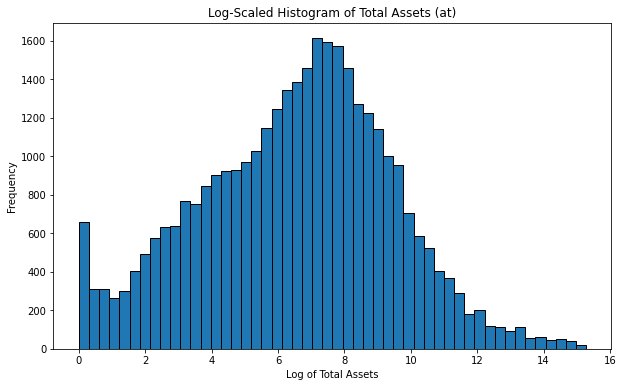

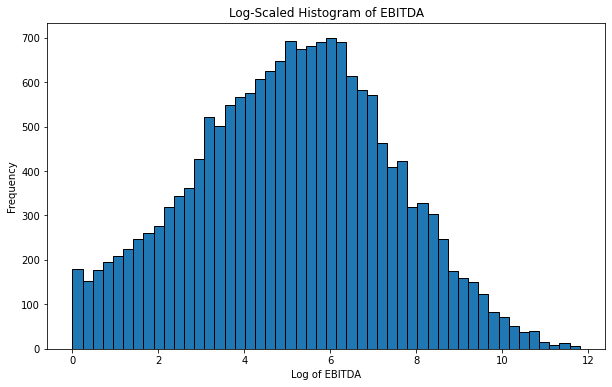

In [9]:
# Remove non-positive values before applying log transformation
at_log = np.log1p(raw_df['at'][raw_df['at'] > 0].dropna())
ebitda_log = np.log1p(raw_df['ebitda'][raw_df['ebitda'] > 0].dropna())

# Log-scaled Histogram for 'at' (Total Assets)
plt.figure(figsize=(10, 6))
plt.hist(at_log, bins=50, edgecolor='black')
plt.title('Log-Scaled Histogram of Total Assets (at)')
plt.xlabel('Log of Total Assets')
plt.ylabel('Frequency')
plt.show()

# Log-scaled Histogram for 'ebitda'
plt.figure(figsize=(10, 6))
plt.hist(ebitda_log, bins=50, edgecolor='black')
plt.title('Log-Scaled Histogram of EBITDA')
plt.xlabel('Log of EBITDA')
plt.ylabel('Frequency')

plt.show()

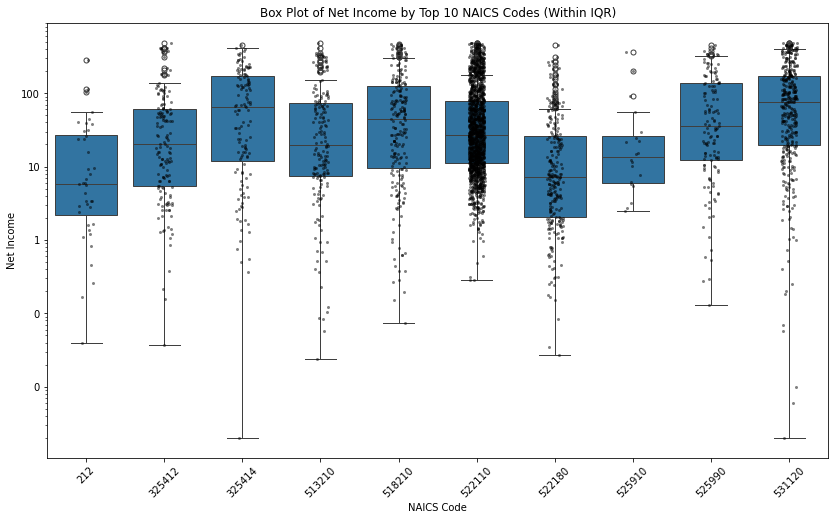

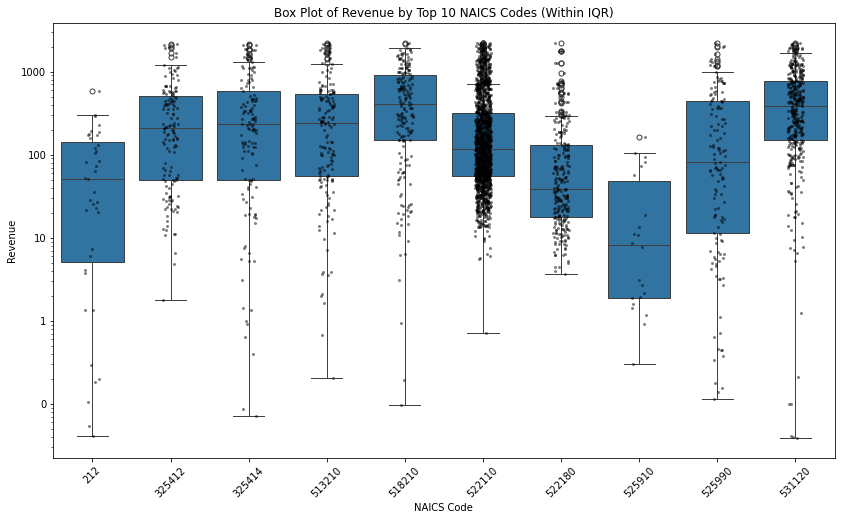

In [10]:
# Get the top 10 most frequent NAICS codes
top_naics_codes = raw_df['naics'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top NAICS codes and positive values
filtered_df = raw_df[raw_df['naics'].isin(top_naics_codes)]
filtered_df = filtered_df[(filtered_df['ni'] > 0) & (filtered_df['revt'] > 0)]

# Filtered data within IQR for 'ni' and 'revt'
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    return df[(df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))]

filtered_df_ni = remove_outliers_iqr(filtered_df, 'ni')
filtered_df_revt = remove_outliers_iqr(filtered_df, 'revt')

# Convert NAICS codes to integers
filtered_df['naics'] = filtered_df['naics'].astype(int)

# Box plot for 'ni' (Net Income) by NAICS within IQR with jittered outliers and custom y-ticks
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_df_ni, x='naics', y='ni', fliersize=5)
sns.stripplot(data=filtered_df_ni, x='naics', y='ni', color='black', size=3, jitter=True, alpha=0.5)
plt.title('Box Plot of Net Income by Top 10 NAICS Codes (Within IQR)')
plt.xlabel('NAICS Code')
plt.ylabel('Net Income')
plt.xticks(
    ticks=range(len(filtered_df['naics'].unique())), 
    labels=[str(int(naics)) for naics in sorted(filtered_df['naics'].unique())],
    rotation=45
)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))  # No scientific notation
plt.show()

# Box plot for 'revt' (Revenue) by NAICS within IQR with jittered outliers and custom y-ticks
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_df_revt, x='naics', y='revt', fliersize=5)
sns.stripplot(data=filtered_df_revt, x='naics', y='revt', color='black', size=3, jitter=True, alpha=0.5)
plt.title('Box Plot of Revenue by Top 10 NAICS Codes (Within IQR)')
plt.xlabel('NAICS Code')
plt.ylabel('Revenue')
plt.xticks(
    ticks=range(len(filtered_df['naics'].unique())), 
    labels=[str(int(naics)) for naics in sorted(filtered_df['naics'].unique())],
    rotation=45
)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))  # No scientific notation

plt.show()

<h1 style="font-family: Georgia; font-size: 4em; color: blue; font-style: bold;">2. Data Preprocessing</h1>

<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">2.1 Missing Data</h2>

In [11]:
# Examine the data for missing values

raw_df.isnull().sum()

gvkey           0
datadate        0
fyear           0
tic            20
curcd           0
act         24368
at          15796
ceq         15878
csho         4773
ebitda      20662
lct         24341
lt          15846
ni          19803
ppegt       22690
revt        15903
costat          0
prcc_c       3032
prcc_f       2787
naics        1496
dtype: int64

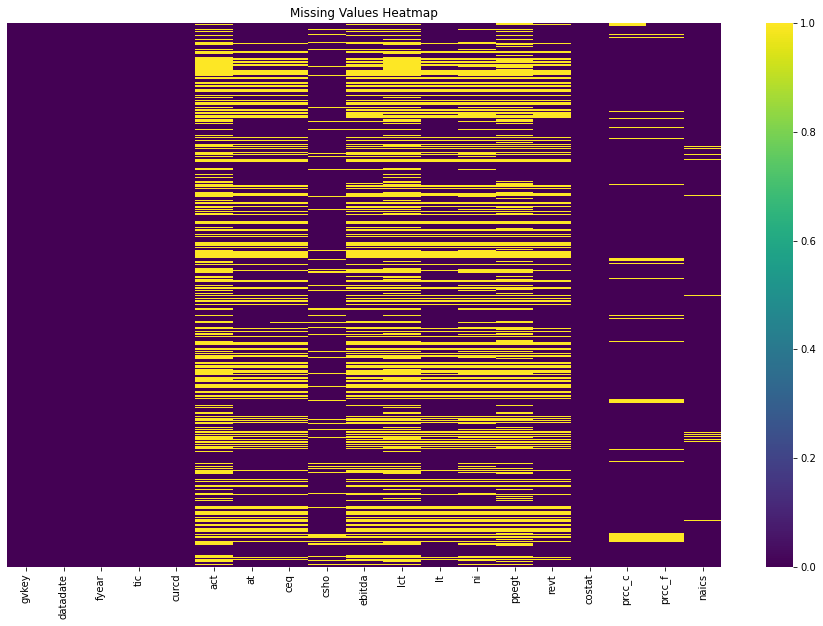

In [12]:
# Assuming your DataFrame is called raw_df
plt.figure(figsize=(16, 10))  # Increase plot size
sns.heatmap(raw_df.isnull(), cbar=True, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.xticks(rotation=90)  # Rotate column names for readability

plt.show()

### CARE: Before processing missing values, it's important to understand the patterns, context, and impact on the model!

Here we're going to perform a brutal deletion. However, deleting rows with missing values can lead to several issues, including sample size reduction, bias, unbalanced panel data, and loss of longitudinal information. It’s important to assess the extent and nature of missing data before deleting rows and to consider alternative strategies like imputation or using models that handle missing data effectively.

In [13]:
# Copy the original DataFrame to avoid modifying it directly
preprocessed_df = raw_df.copy()

In [14]:
# Drop missing values in numerical columns.
preprocessed_df = preprocessed_df.dropna()


<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">2.2 Feature Engineering - Create financial ratios</h2>

In [15]:
# Remove "denominator" records with ZERO values

num_removed = preprocessed_df.shape[0] - preprocessed_df[preprocessed_df['revt'] != 0].shape[0]
print(f"Number of observations with zero revenue: {num_removed}")
num_removed = preprocessed_df.shape[0] - preprocessed_df[preprocessed_df['at'] != 0].shape[0]
print(f"Number of observations with zero total assets: {num_removed}")
num_removed = preprocessed_df.shape[0] - preprocessed_df[preprocessed_df['lct'] != 0].shape[0]
print(f"Number of observations with zero current liabilities: {num_removed}")

# Drop denominator observations with zero values
preprocessed_df = preprocessed_df[preprocessed_df['revt'] != 0]
#preprocessed_df = preprocessed_df[preprocessed_df['at'] != 0]
#preprocessed_df = preprocessed_df[preprocessed_df['lct'] != 0]


Number of observations with zero revenue: 3117
Number of observations with zero total assets: 96
Number of observations with zero current liabilities: 20


In [16]:
# Calculate the financial ratios

# Handling ZEROs in denominators by adding and epsilon (small constant) to avoid DbZs
epsilon = 1e-6

preprocessed_df['roa'] = preprocessed_df['ni'] / (preprocessed_df['at'].replace(0, epsilon))
preprocessed_df['debt_equity'] = preprocessed_df['lt'] / (preprocessed_df['at'].replace(0, epsilon))
preprocessed_df['current_ratio'] = preprocessed_df['act'] / (preprocessed_df['lct'].replace(0, epsilon))
preprocessed_df['profit_margin'] = preprocessed_df['ni'] / (preprocessed_df['revt'].replace(0, epsilon))
preprocessed_df['asset_turnover'] = preprocessed_df['revt'] / (preprocessed_df['at'].replace(0, epsilon))
preprocessed_df['ebitda_margin'] = preprocessed_df['ebitda'] / (preprocessed_df['revt'].replace(0, epsilon))

# Calculate market capitalization
preprocessed_df['mktcap'] = preprocessed_df['csho'] * preprocessed_df['prcc_f']

# Keep only positive 'mktcap' values
preprocessed_df = preprocessed_df[preprocessed_df['mktcap'] > 0]


<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">2.3 Outliers</h2>

Outliers can be handled by using methods such as trimming, winsorizing, z-score filtering, IQR filtering, and transformations. Students are encouraged to research these techniques to understand their application and impact on data analysis.

In this instance we are going to remove outliers and other variables with extreme values through winsorization.

In [17]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
from scipy.stats.mstats import winsorize

# Get list of numerical columns which call 'fundamentals' to distinguish from the financial ratios which we will create later
fundamental_cols = preprocessed_df.select_dtypes(include=[np.number]).columns


# List of columns to exclude from transformations
columns_to_exclude = ['gvkey', 'datadate', 'curcd', 'costat', 'fyear', 'naics']

# Remove the excluded columns from the list of numerical columns
fundamental_cols = fundamental_cols.difference(columns_to_exclude)

# Winsorize numerical columns to limit the impact of outliers
for col in fundamental_cols:
    # Adjust limits as needed; currently set to cap the lowest and highest 1%
    preprocessed_df[col] = winsorize(preprocessed_df[col], limits=[0.01, 0.01])

# Convert the masked array to a regular numpy array
    preprocessed_df[col] = np.asarray(preprocessed_df[col])

<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">2.4 Data Transformations</h2>

When preparing data for analysis, particularly in panel data models, it’s important to address two key preprocessing techniques: **transformation** and **scaling**.

 

<h3 style="font-family: Georgia; font-size: 2em; color: blue; font-style: bold;">2.4.1 Yeo-Johnson Transformation</h3>

In [18]:
# Initialize the transformer
pt = PowerTransformer(method='yeo-johnson', standardize=False)

# Apply the transformation to the numerical columns
preprocessed_df[fundamental_cols] = pt.fit_transform(preprocessed_df[fundamental_cols])

<h3 style="font-family: Georgia; font-size: 2em; color: blue; font-style: bold;">2.4.2 Scaling</h3>

After transformation, the scaling step standardizes both the transformed and other variables, ensuring they all have a mean of 0 and a standard deviation of 1.

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the numerical columns
preprocessed_df[fundamental_cols] = scaler.fit_transform(preprocessed_df[fundamental_cols])

# The DataFrame preprocessed_df now has transformed numerical columns, with specified columns untouched

<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">2.5 Visual Analysis of pre-processed data</h2>

<h3 style="font-family: Georgia; font-size: 2em; color: blue; font-style: bold;">2.5.1 Kernel Density Estimation (KDE) plots</h3>

KDE  plots provide a continuous probability distribution of the data, which is particularly useful for detecting subtle patterns in the data that histograms might miss.

KDE plots are used in business and finance to identify skewness, multimodal distributions, and clustering.


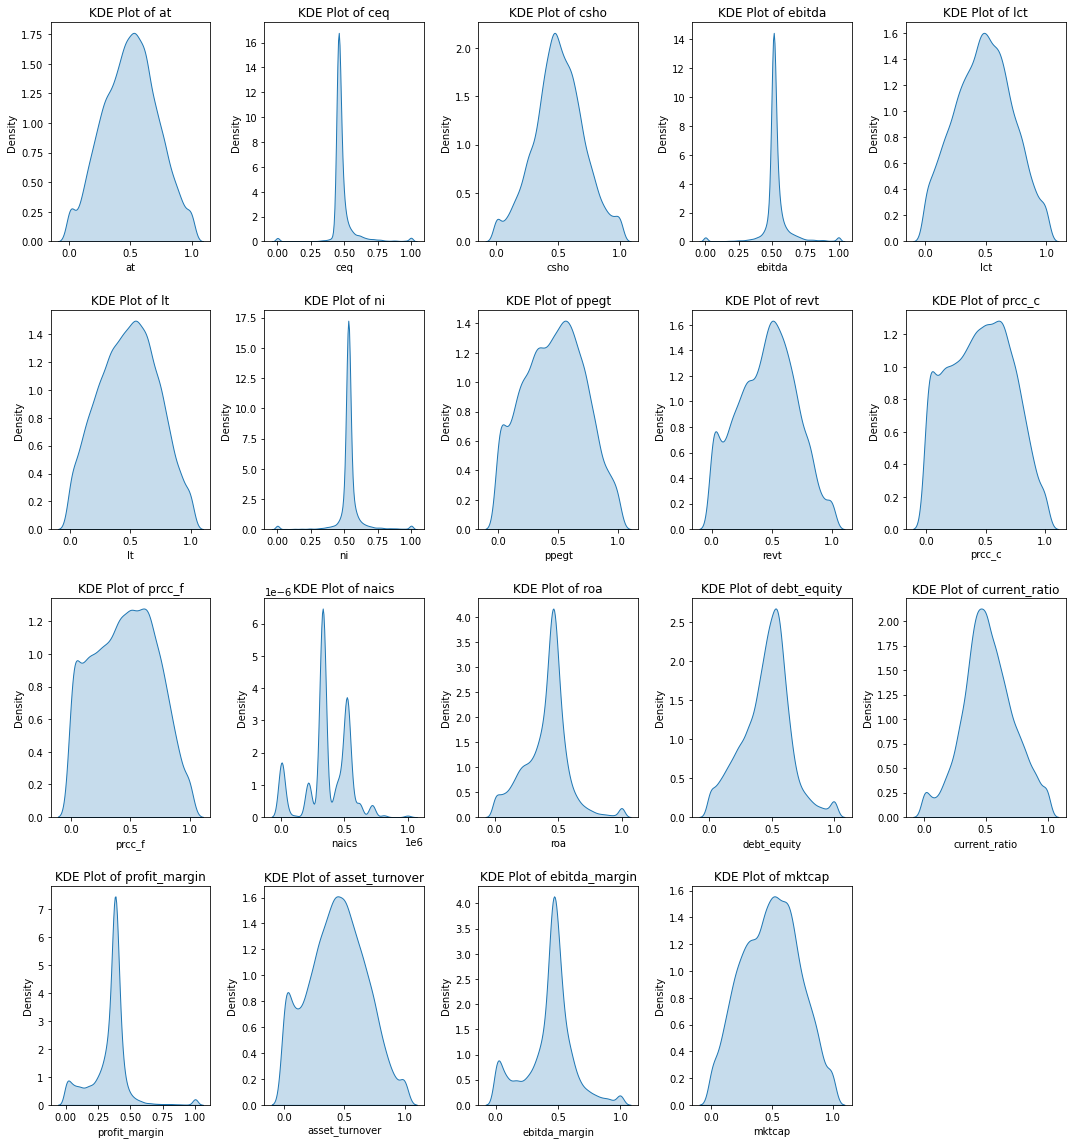

In [20]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns from the preprocessed DataFrame
numerical_columns = preprocessed_df.select_dtypes(include='number').columns

# Determine the number of columns to plot and adjust layout accordingly
num_plots = len(numerical_columns[3:])
rows = (num_plots + 2) // 5  # Adjust rows dynamically based on number of columns

plt.figure(figsize=(15, 4 * rows))  # Increase figure size based on rows

# Plot KDE for each numerical column

for i, col in enumerate(numerical_columns[3:], 1):
    plt.subplot(rows, 5, i)  # Adjust subplot layout based on the number of columns you have
    sns.kdeplot(preprocessed_df[col].dropna(), fill=True)
    plt.title(f'KDE Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()

plt.show()

<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">2.6 Multicollinearity</h2>

Given that several variables may be highly correlated (e.g., **total_assets, marketvalue, mktcap, and size** could be related), we should check for multicollinearity using **pairwise correlations** and the **Variance Inflation Factor (VIF)**.


<h3 style="font-family: Georgia; font-size: 2em; color: blue; font-style: bold;">2.6.1 Pearson correlation coefficient</h3>


The Pearson correlation coefficient measures the linear relationship between two continuous variables.

The Pearson Correlation Coefficient. It ranges from -1 to +1:



Pairwise Correlation Matrix:
                at  roa  ebitda_margin
at            1.00 0.44           0.50
roa           0.44 1.00           0.70
ebitda_margin 0.50 0.70           1.00


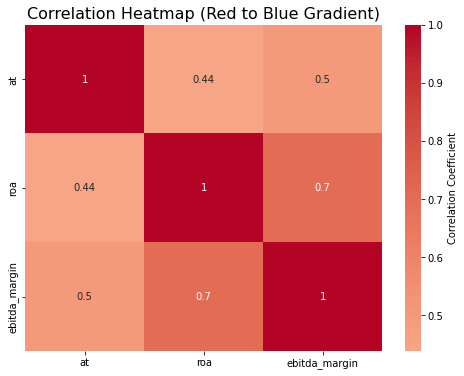

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Full list of ind. variables for selection (cut-n-paste) depending on model being tested
# act', 'at	ceq', 'csho', 'ebitda', 'lct', 'lt', 'ni', 'ppegt', 'revt', 'costat', 'prcc_c', 'prcc_f','mktcap', 'roa', 'debt_equity', 'current_ratio', 'profit_margin', 'asset_turnover', 'ebitda_margin'

# Model set for testing
correlation_testset_df = preprocessed_df[['at', 'roa', 'ebitda_margin']]

# Calculate pairwise correlation for the selected columns
correlation_matrix = correlation_testset_df.corr()
,
print("\nPairwise Correlation Matrix:")

print(correlation_matrix)

# Plot the heatmap using seaborn with a red-to-blue gradient
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Heatmap (Red to Blue Gradient)", fontsize=16)
plt.show()

<h3 style="font-family: Georgia; font-size: 2em; color: blue; font-style: bold;">2.6.2 Variance Inflation Factor (VIF)</h3>

The VIF measures how much the variance of a regression coefficient is inflated due to multicollinearity with other variables.

Use VIF to quantify multicollinearity more precisely in the context of a regression model.

**Even if pairwise correlations are not high, VIF can detect multicollinearity when a variable is correlated with a combination of other variables.**

**A VIF value above 10 indicates high multicollinearity**, meaning the variable is highly correlated with others and may distort the results of the regression model.

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for selected features
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Calculate VIF for the selected columns
vif_df = calculate_vif(correlation_testset_df)
print("Variance Inflation Factor (VIF):\n")
print(vif_df)

Variance Inflation Factor (VIF):

         feature   VIF
0             at  7.02
1            roa 12.00
2  ebitda_margin 12.50


<h3 style="font-family: Georgia; font-size: 2em; color: blue; font-style: bold;">2.6.3 Independent Variable selection criteria</h3>

Based on the correlation, VIF results, and KDE observations:

**Variable Utility:**

- **at** is a stable and relevant predictor, showing reasonable correlations and a VIF below 10. It provides essential information on firm size, which is critical for stock price models.
- **roa** and **ebitda_margin** both capture profitability aspects. The higher VIF and correlation suggest they share overlapping information, which could lead to multicollinearity concerns when both are included.


<h3 style="font-family: Georgia; font-size: 2em; color: blue; font-style: bold;">2.6.4 Further checks</h3>


<h3 style="color: blue; font-style: bold;">i. Assessing Linearity with the Dependent Variable</h3>

As we’re planning a regression-based model (PanelOLS), it’s important to check for linear relationships between the independent variables and the dependent variable (prcc_f).

Here well use scatter plots with regression lines to visually confirm linearity between each independent variable and prcc_f: 

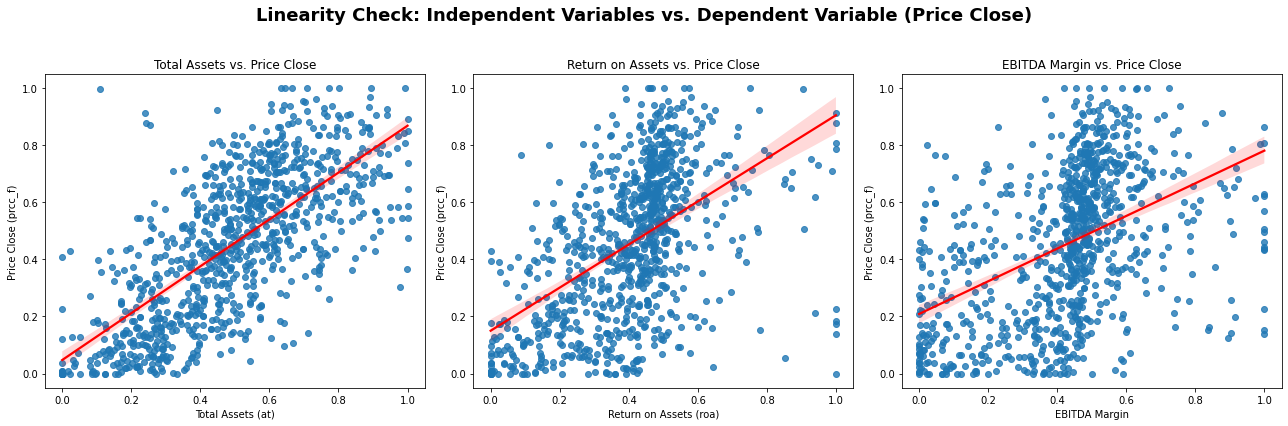

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subsample the data to improve performance
sample_df = preprocessed_df.sample(frac=0.05, random_state=1)  # Adjust the sampling fraction if needed

# Set up individual scatter plots with regression lines for each independent variable against `prcc_f`
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Total Assets vs. Price Close
sns.regplot(x='at', y='prcc_f', data=sample_df, ax=axs[0], line_kws={'color': 'red'})
axs[0].set_title('Total Assets vs. Price Close')
axs[0].set_xlabel('Total Assets (at)')
axs[0].set_ylabel('Price Close (prcc_f)')

# Return on Assets vs. Price Close
sns.regplot(x='roa', y='prcc_f', data=sample_df, ax=axs[1], line_kws={'color': 'red'})
axs[1].set_title('Return on Assets vs. Price Close')
axs[1].set_xlabel('Return on Assets (roa)')
axs[1].set_ylabel('Price Close (prcc_f)')

# EBITDA Margin vs. Price Close
sns.regplot(x='ebitda_margin', y='prcc_f', data=sample_df, ax=axs[2], line_kws={'color': 'red'})
axs[2].set_title('EBITDA Margin vs. Price Close')
axs[2].set_xlabel('EBITDA Margin')
axs[2].set_ylabel('Price Close (prcc_f)')

plt.suptitle('Linearity Check: Independent Variables vs. Dependent Variable (Price Close)\n',
    fontsize=18,  # Adjust font size
    fontweight='bold',  # Adjust font weight, options: 'normal', 'bold', 'heavy', 'light'
#    fontstyle='italic',  # Adjust font style, options: 'normal', 'italic', 'oblique'
    family='sans-serif')  # Font family, options include: 'serif', 'sans-serif', 'monospace', etc.


plt.tight_layout()

plt.show()

___
<h3 style="color: blue; font-style: bold;">ii. Testing for Heteroscedasticity</h3>

Heteroscedasticity occurs when the variance of errors is not constant, which can violate regression assumptions and affect the reliability of coefficient estimates.

We're going to use a Residual Plot, after running an PooledOLS or PanelOLS regression. Ideally, the residuals should show **no pattern** when plotted against predicted values or independent variables. 


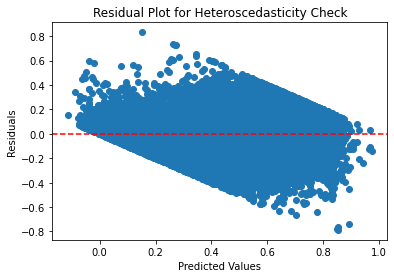

In [24]:
# Prepare a straightforward OLS model
X = preprocessed_df[['at', 'roa', 'ebitda_margin']]
X = sm.add_constant(X)
y = preprocessed_df['prcc_f']

model = sm.OLS(y, X).fit()
residuals = model.resid

# Plot the residuals
plt.scatter(model.predict(X), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Heteroscedasticity Check')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.show()

___
<h3 style="color: blue; font-style: bold;">iii. Normality of Residuals</h3>

In regression models, normality of residuals is generally assumed for inference i.e. to trust p-values and confidence intervals.

After fitting a model, plot a **QQ plot of the residuals**. This helps visualize if residuals follow a normal distribution. While PanelOLS doesn’t require strict normality, this step helps ensure the reliability of hypothesis testing

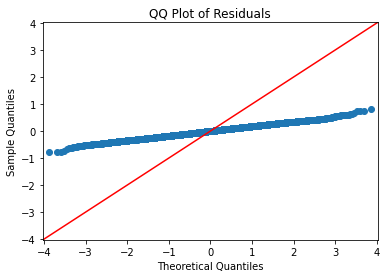

In [25]:
sm.qqplot(residuals, line='45')

plt.title('QQ Plot of Residuals')

plt.show()

___
<h3 style="color: blue; font-style: bold;">iv. Panel-Specific Considerations: Time Series Stationarity</h3>

Since we’re working with panel data, it’s crucial to ensure the variables don’t have trends over time that could lead to spurious relationships. This  abscence of trending is called **stationarity**.

To test for stationarity, we can apply unit root tests such as the Augmented Dickey-Fuller (ADF) or Levin-Lin-Chu (LLC) tests on panel data. This is especially important if any variable tends to drift over time.

In [26]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic for {title}: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Result: {"Stationary" if result[1] < 0.05 else "Non-stationary"}')

adf_test(preprocessed_df['at'], title='Total Assets (at)')
print("\n")
adf_test(preprocessed_df['roa'], title='Return on Assets (roa)')
print("\n")
adf_test(preprocessed_df['ebitda_margin'], title='EBITDA Margin')


ADF Statistic for Total Assets (at): -12.665647675400884
p-value: 1.2765856555409281e-23
Result: Stationary


ADF Statistic for Return on Assets (roa): -9.529113373221847
p-value: 2.92310369739722e-16
Result: Stationary


ADF Statistic for EBITDA Margin: -9.455441488592422
p-value: 4.498232143534008e-16
Result: Stationary


<h3 style="color: blue; font-style: bold;">Visualising panel data: Facet Grid for Entity-Level Analysis (best for Cross-Entity Comparison)</h3>

This is ideal when you want to observe trends over time within individual entities and compare these trends across multiple entities.

Facet grids allow you to plot each entity in its own subplot, so you can easily see whether patterns in one entity apply across others without overcrowding a single plot.

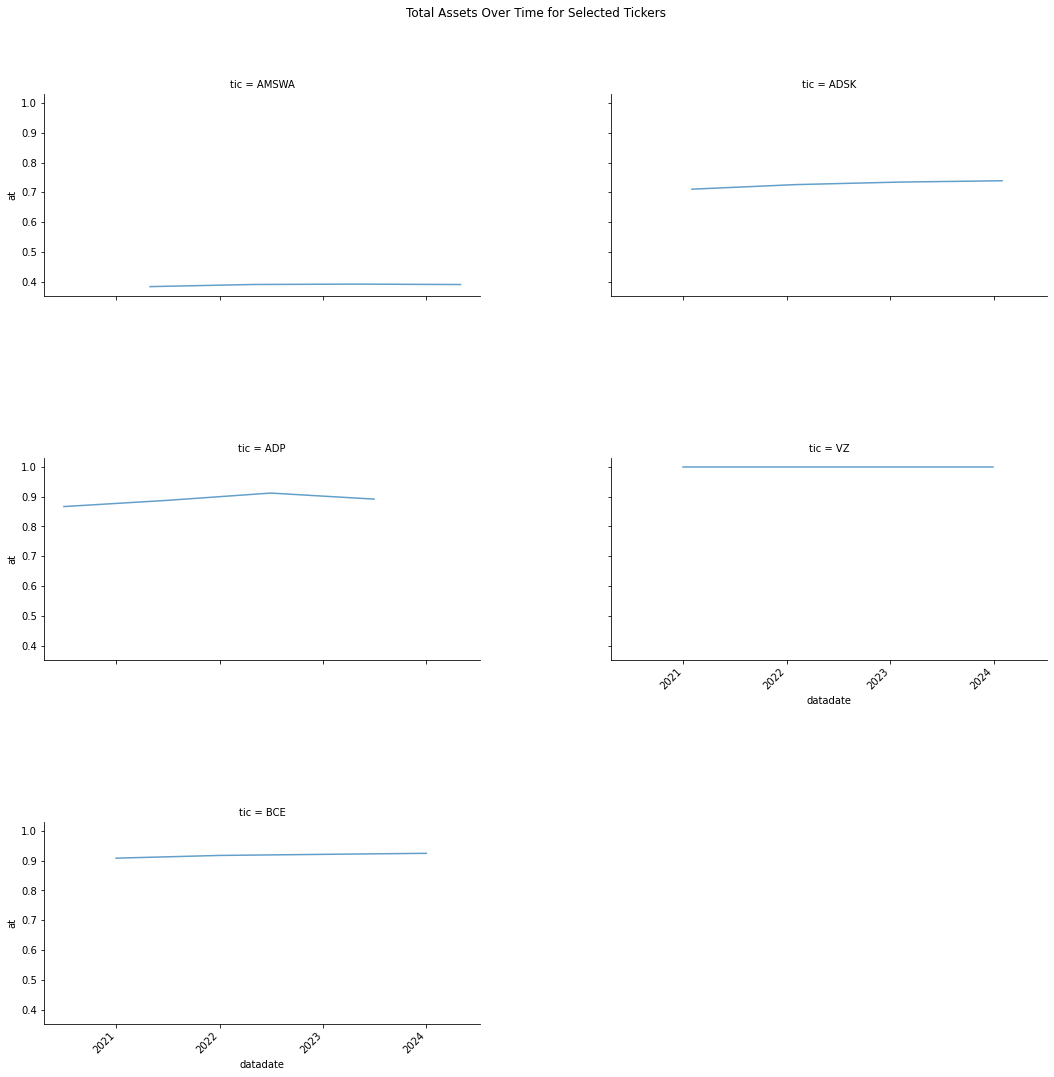

In [27]:
import matplotlib.dates as mdates  # Import mdates for date handling

# Convert 'datadate' to datetime with error handling
preprocessed_df['datadate'] = pd.to_datetime(preprocessed_df['datadate'], format='%d/%m/%Y', dayfirst=True, errors='coerce')

# Filter for tech firms based on NAICS code starting with '51' and select the first N unique firms
tech_firms_df = preprocessed_df[preprocessed_df['naics'].astype(str).str.startswith('51')]  # 511210 are software firms
sample_entities = tech_firms_df['tic'].unique()[:5]  # Get the first 5 unique tickers

# Filter the original DataFrame for these selected tickers
sample_df = preprocessed_df[preprocessed_df['tic'].isin(sample_entities)].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Use FacetGrid to plot Total Assets (at) over time for each selected entity (ticker)
g = sns.FacetGrid(sample_df, col="tic", col_wrap=2, height=5, aspect=1.5)
g.map(plt.plot, "datadate", "at", alpha=0.7)

# Set the x-axis to show year format and rotate for readability
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Major tick every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Year format for labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Adjust the layout for better spacing
plt.subplots_adjust(top=0.9, hspace=0.8, wspace=0.3)
g.fig.suptitle('Total Assets Over Time for Selected Tickers')

plt.show()



<h3 style="font-family: Georgia; font-size: 2em; color: blue; font-style: bold;">2.6.5 Lagging variables</h3>

Let's look at incorporating lagged variables as predictors for **prcc_f** (closing price). Lagged variables represent past values of certain financial metrics, and they help us explore whether these past values have predictive power for the current stock price.

For instance, imagine we’re looking at the impact of past total assets (**at**) on today’s stock price. By including **lag_at** (total assets from a previous period), we’re considering whether a company’s historical asset size influences its current stock price. This is useful because assets may take time to impact market perception and, therefore, the stock price.

Similarly, we might include **lag_roa** or **lag_ebitda_margin**  - these are just previous values of the company's return on assets and EBITDA margin, respectively. By doing this, we’re assessing whether past profitability or efficiency indicators continue to affect the stock price.


In [28]:
# Prepare lagged variables

# preprocessed_df['roa'] = preprocessed_df.groupby('isin')['roa'].shift(1)

# preprocessed_df['lag_mean_return'] = preprocessed_df.groupby('isin')['mean_return'].shift(1)

# preprocessed_df['lag_vol'] = preprocessed_df.groupby('isin')['vol'].shift(1)

# preprocessed_df['lag_liquidity'] = preprocessed_df.groupby('isin')['liquidity'].shift(1)

# preprocessed_df['lag_mktcap'] = preprocessed_df.groupby('isin')['mktcap'].shift(1)

# preprocessed_df['lag_tangibility'] = preprocessed_df.groupby('isin')['tangibility'].shift(1)
# preprocessed_df['lag_beta'] = preprocessed_df.groupby('isin')['beta'].shift(1)


___
<h1 style="font-family: Georgia; font-size: 4em; color: blue; font-style: bold;">3. Pooled Data Analysis</h1>

We begin our panel data exploration with **pooled data** analysis. We're doing this because as a reminder of the fundamental concepts in a familiar regression framework. 

In pooled data analysis, we treat all observations (across time and entities, such as firms) as a single dataset, ignoring the panel structure. This allows students to grasp the basic relationships between variables without considering the complexities of individual and time-specific effects. 

By using **pooled OLS** as the baseline, we are able to see the limitations of ignoring firm-specific characteristics and time dynamics, which naturally leads into the more sophisticated methods of Fixed Effects and Random Effects models. 

This step-by-step approach helps us build an understanding of why more advanced methods are needed and how those methods account for the unobserved heterogeneity and temporal dependencies inherent in financial panel data.

In [29]:
# Create a function to print (html) 2 regression summaries side by side ...

def combine_summaries(summary1_html, summary2_html):
    combined_html = f"""
    <div style="display: flex; flex-direction: row; justify-content: space-around;">
        <div style="width: 45%; padding-right: 2.5%;">
            {summary1_html}
        </div>
        <div style="width: 45%; padding-left: 2.5%;">
            {summary2_html}
        </div>
    </div>
    """
    return combined_html

<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">3.1 Run pooled OLS regression on the data</h2>

In [30]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

pooled_ols_df = preprocessed_df.copy()

pooled_ols_df['naics_subsector'] = pooled_ols_df['naics'].astype(str).str[:2]


# Net income determination
# ols_formula = 'ni ~ lt + revt + C(fyear)'

# Stock price determination
ols_formula = 'prcc_f ~ at + roa + ebitda_margin + C(fyear) + C(naics_subsector)'

# Define the model using smf.OLS, treating 'fyear' as a categorical variable
pooled_ols_results = smf.ols(formula = ols_formula, data = pooled_ols_df).fit(cov_type='cluster', cov_kwds={'groups': pooled_ols_df['tic']})

# Print the model summary
print(pooled_ols_results.summary())


                            OLS Regression Results                            
Dep. Variable:                 prcc_f   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     395.5
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:00:59   Log-Likelihood:                 6659.2
No. Observations:               18482   AIC:                        -1.326e+04
Df Residuals:                   18453   BIC:                        -1.303e+04
Df Model:                          28                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Notes:

- Clustering on **tic** (firm ID) adjusts the standard errors to account for within-firm correlation over time. This is important because observations within the same firm may not be independent.
- For datasets with a manageable number of years, including **C(fyear)** is computationally feasible. If we have a very large number of years, the model may become complex due to the number of dummy variables.



<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">3.2 Analysis - Pooled OLS results</h2>

### **Model summary**

Number of Observations: 71,436
Degrees of Freedom (Model): 39
Degrees of Freedom (Residual): 71,396

**R-squared:** 0.601
Indicates that 60.1% of the variability in prcc_f is explained by the model.

**Adjusted R-squared:** 0.601
Adjusted for the number of predictors, confirming the explanatory power remains strong.

**F-statistic:** 562.0
Suggests the model is statistically significant overall.

**Prob (F-statistic):** 0.00
The probability of observing such an F-statistic under the null hypothesis is virtually zero.



<h1 style="font-family: Georgia; font-size: 4em; color: blue; font-style: bold;">4. Panel Data Modeling - Fixed Effects</h1>

 ......

In [31]:
from IPython.display import display, HTML
import io

# Take a copy of the filtered data
panel_ols_df = preprocessed_df.copy()

# Set the multi-index (panel data structure)
panel_ols_df = panel_ols_df.set_index(['tic', 'fyear'])

<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">4.1 Run a Fixed-Effects Panel OLS regression</h2>

In [32]:
# Prepare the dependent and independent variables
dependent_var = panel_ols_df['prcc_f']
independent_vars = panel_ols_df[['at', 'roa', 'ebitda_margin']]

# Include sector effects n-digit NAICS subsector code???? see what happens to the model

# panel_ols_df['sub_sector'] = panel_ols_df['naics'].astype(str).str[:2]
# panel_ols_df['sub_sector'] = panel_ols_df['sub_sector'].astype('category')
# # Create dummy variables for 'sub_sector'
# sub_sector_dummies = pd.get_dummies(panel_ols_df['sub_sector'], prefix='sector', drop_first=True)
# # Combine independent_vars with sub_sector_dummies
# independent_vars = pd.concat([independent_vars, sub_sector_dummies], axis=1)


# Running the fixed-effects model using PanelOLS with entity and time effects
mtb_fe_model = PanelOLS(dependent_var, independent_vars, entity_effects=True, time_effects=True)

# Fitting the model with robust standard errors
panel_fe_results_unadj = mtb_fe_model.fit(cov_type='unadjusted')                              # Standard errors are not clustered
panel_fe_results_clustered = mtb_fe_model.fit(cov_type='clustered', cluster_entity=True)      # Cluster standard errors

# Display the combined summaries
display(HTML(combine_summaries(panel_fe_results_unadj.summary.as_html(), panel_fe_results_clustered.summary.as_html())))

Dep. Variable:,prcc_f,R-squared:,0.0966
Estimator:,PanelOLS,R-squared (Between):,0.8005
No. Observations:,18482,R-squared (Within):,0.0848
Date:,"Mon, Oct 28 2024",R-squared (Overall):,0.7908
Time:,12:00:59,Log-likelihood,2.564e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,451.89
Entities:,5801,P-value,0.0000
Avg Obs:,3.1860,Distribution:,"F(3,12675)"
Min Obs:,1.0000,,
Max Obs:,4.0000,F-statistic (robust):,451.89


<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">4.2 Analysis - FE results</h2>

### **Model focus**

This analysis of results will focus on the second model, which employs a **Clustered Covariance Estimator**. This model is considered superior for the following reasons:

**Robust Standard Errors:** Clustering adjusts the standard errors to account for potential correlation within clusters (e.g., entities or time periods). This leads to more reliable statistical inferences by correcting for heteroskedasticity and autocorrelation that may bias the results in panel data.

**Panel Data Characteristics:** Given the structure of the data—with multiple observations per entity over time—there is a high likelihood of correlated errors within entities. The clustered estimator appropriately addresses this issue.

**Conservative Inference:** Clustered standard errors are typically larger than unadjusted ones, providing a more conservative approach to hypothesis testing. This reduces the risk of Type I errors (false positives).

### Discussion

**Within-Entity Variation:** The relatively low within R-squared suggests that the model may not fully capture the time-varying factors affecting the dependent variable within entities. Exploring additional time-varying predictors or dynamic models may improve this.

**Potential Endogeneity:** There may be reverse causality or omitted variable bias. For instance, higher prcc_f could lead to increases in total assets. Instrumental variable techniques could address this issue.

**Heterogeneity Across Entities:** While fixed effects control for unobserved heterogeneity, there may be heterogeneous effects of predictors across different types of entities. Random coefficient models or interaction terms could explore this further.

### Conclusions

The model utilizing a clustered covariance estimator, provides a robust and reliable analysis of the factors influencing prcc_f. 

The significant positive relationships with total assets, return on assets, and EBITDA margin suggest the relevance of company size and profitability in determining financial performance. 

By accounting for potential within-entity correlation, the model offers trustworthy insights that can inform decision-making across various stakeholders.

<h2 style="font-family: Georgia; font-size: 3em; color: blue; font-style: bold;">4.3 Compare FE and Pooled model results</h2>

We'll first compare the results of both **pooled** and **PanelOLS - Fixed Effects (clustered)** and analyse the results of the two models.


In [33]:
# Display the combined summaries
display(HTML(combine_summaries(pooled_ols_results.summary().as_html(), panel_fe_results_clustered.summary.as_html())))

# Model Preference and Recommendation  

Based on the analysis, the PanelOLS model is preferred over the OLS model for the following reasons:

**Control for Unobserved Heterogeneity:**  

The PanelOLS model includes entity fixed effects, accounting for unobserved, time-invariant characteristics of each entity (e.g., company culture, management practices). This reduces omitted variable bias and provides more reliable estimates.  

**Model Fit:**  

Higher R-squared values in the PanelOLS model indicate a better fit.
The model explains more variation in the dependent variable.

**Significance of Variables:**

The PanelOLS model finds ebitda_margin to be a significant predictor, which is theoretically consistent if operational efficiency impacts financial performance.
The OLS model may overlook important effects due to not accounting for entity-specific factors.

**Statistical Robustness:**

Both models use clustered standard errors, but the PanelOLS model's adjustments for panel data make it more appropriate for this dataset.

# Limitations

**Non-Normality of Residuals:**

Diagnostic tests suggest residuals are not normally distributed.  
Consider using robust regression techniques or transforming variables.

**Multicollinearity:**  

Although the condition number is below critical thresholds, further checks (e.g., Variance Inflation Factor) are recommended.

**Omitted Variable Bias:**  

The OLS model may suffer from omitted variable bias due to not controlling for entity-specific effects.
Ensure all relevant variables are included, or prefer models that control for unobserved heterogeneity (like PanelOLS).

**Effect of Industry Classification:**

The significance of industry dummies suggests industry-specific factors are important.
Explore industry-specific models or include additional industry-related variables.

# Conclusion  
The OLS regression provides valuable insights but is less comprehensive than the PanelOLS model due to its inability to control for unobserved entity-specific effects. The PanelOLS model is better suited for panel data analysis, offering more reliable estimates and a better understanding of the factors influencing prcc_f.

Key Takeaways:

Total Assets and Return on Assets are significant predictors across both models, reinforcing their importance in financial performance.
EBITDA Margin's significance in the PanelOLS model highlights the need to consider entity-specific effects.
Model Selection Matters: Choosing the appropriate econometric model is crucial for accurate analysis and interpretation.
Next Steps:

Adopt PanelOLS as the primary model for future analyses.
Address Diagnostic Issues: Tackle non-normality and potential multicollinearity to improve model robustness.
Expand Research: Consider additional variables or alternative models to further explore the determinants of prcc_f.


In [34]:
# Performing an Ftestdetails (for individual firm effects)
from scipy.stats import f

# Calculate the sum of squared residuals for the panel FE
ssr_fe = (panel_fe_results_clustered.resids ** 2).sum()

# Calculate the sum of squared residuals for the pooled data
# smf.ols residuals are access by resid
pooled_residuals = pooled_ols_results.resid
ssr_pooled = (pooled_residuals ** 2).sum()

# Calculate degrees of freedom
# are 'tic' and 'fyear' already set as indices for panel data structure?
pooled_ols_df = pooled_ols_df.set_index(['tic', 'fyear'])
n_entities = pooled_ols_df.index.get_level_values('tic').nunique()
n_obs = pooled_ols_df.shape[0]

df_num = n_entities - 1  # Degrees of freedom numerator
df_den = n_obs - n_entities - panel_fe_results_clustered.params.shape[0]  # Degrees of freedom denominator

# Compute the F-statistic
F_stat = ((ssr_pooled - ssr_fe) / df_num) / (ssr_fe / df_den)

# Compute the p-value
p_value = 1 - f.cdf(F_stat, df_num, df_den)

print(f'F-statistic: {F_stat:.4f}')
print(f'P-value: {p_value:.4f}')

# Interpret the result
if p_value < 0.05:
    print('Firm fixed effects are significant. The fixed effects model is preferred in this case.')
else:
    print('Firm fixed effects are not significant. The pooled OLS model is preferred in this case.')


F-statistic: 14.8568
P-value: 0.0000
Firm fixed effects are significant. The fixed effects model is preferred in this case.


<h1 style="font-family: Georgia; font-size: 4em; color: blue; font-style: bold;">5. Logistic Regression - Worked example</h1>

## <span style="color:blue">5.1 Create, train and fit the model</span>

In [35]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)

# Make a copy of the preprocessed DataFrame
credit_risk_df = preprocessed_df.copy()

# Sort by company ticker ('tic') and financial year ('fyear'), descending to prioritize the most recent years
credit_risk_df = credit_risk_df.sort_values(by=['tic', 'fyear'], ascending=[True, False])

# Create the 'credit_risk' column based on financial thresholds
# Example thresholds: debt_to_equity > 2 OR ROA < 0.1
credit_risk_df['credit_risk'] = (
    (credit_risk_df['debt_equity'] > 2) | (credit_risk_df['roa'] < 0.1)
).astype(int)

# Optional: Filter companies with at least three years of data
company_counts = credit_risk_df['tic'].value_counts()
sufficient_data_companies = company_counts[company_counts >= 3].index
credit_risk_df = credit_risk_df[credit_risk_df['tic'].isin(sufficient_data_companies)]

# Filter to keep only the most recent three years of data for each firm
credit_risk_df = credit_risk_df.groupby('tic').head(3)

# Group by firm and calculate the mean of the financial indicators over the last three years
credit_risk_company_level = credit_risk_df.groupby('tic').agg({
    'debt_equity': 'mean',        # Mean debt-to-equity ratio over three years
    'roa': 'mean',                # Mean return on assets (ROA) over three years
    'current_ratio': 'mean',      # Mean current ratio over three years
    'credit_risk': 'max'          # High-risk if flagged in any of the past three years
}).reset_index()

# Define feature matrix X and target vector y for the logistic regression
X = credit_risk_company_level[['debt_equity', 'roa', 'current_ratio']]
y = credit_risk_company_level['credit_risk']  # High-risk if flagged in any of the three years

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the logistic regression model on the training data
logit_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logit_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logit_model.predict(X_test)


## <span style="color:blue">5.2. Results and interpretation</span>

### <span style="color:blue">5.2.1 McFadden R-squared</span>

**McFadden's R-squared** is a measure of the goodness-of-fit for logistic regression models. It is conceptually similar to the R-squared used in linear regression, but is designed for models where the dependent variable is binary, such as logistic regression.

#### Formula:  

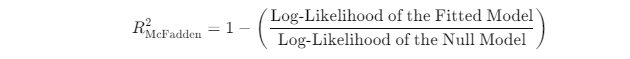

- **Log-Likelihood of the fitted model (LL_model)**: This represents how well the logistic regression model fits the actual data.
- **Log-Likelihood of the null model (LL_null)**: This represents the fit of a model with only an intercept (no independent variables).

#### Interpretation:
- A McFadden's R-squared value ranges between 0 and 1, where values closer to 1 indicate a better fit of the model to the data.

In [36]:
# Get the predicted probabilities for the actual class labels
y_pred_prob = logit_model.predict_proba(X)[:, 1]

# Clip predicted probabilities to prevent log(0) errors
epsilon = 1e-15
y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)

# Log-likelihood of the fitted model
ll_model = np.sum(y * np.log(y_pred_prob) + (1 - y) * np.log(1 - y_pred_prob))

# Log-likelihood of the null model (intercept only)
y_mean = np.mean(y)
ll_null = np.sum(y * np.log(y_mean) + (1 - y) * np.log(1 - y_mean))

# McFadden's R-squared
mcfadden_r2 = 1 - (ll_model / ll_null)
print(f"McFadden's R-squared: {mcfadden_r2:.4f}")


McFadden's R-squared: 0.1377


###  <span style="color:blue">5.2.2 Significance Testing in Logistic Regression - Chi squared</span>

In non-linear models such as **logistic regression**, significance testing is used to determine whether the relationships between the independent variables and the predicted outcome are statistically significant.

Unlike **linear regression**, where significance testing focuses on the linear relationship between variables, **logistic regression** deals with probabilities and categorical outcomes (e.g., high risk vs. low risk).

- **Chi-squared Statistic**: Measures how well the model's predictions fit the observed outcomes. A large value suggests a significant difference between predicted and observed data.
- **P-value**: The P-value represents the probability that the observed differences occurred by chance. A low P-value (typically < 0.05) indicates that the model's predictors are significantly related to the outcome.
- **Degrees of Freedom (DoF)**: Reflects the number of categories or independent variables being tested, which affects the critical value needed to assess significance.

In non-linear models, significance testing helps evaluate whether the model meaningfully predicts the categorical outcome, distinguishing it from linear regression's focus on continuous outcomes.


In [37]:
from scipy import stats

# Get predicted probabilities for the test set
y_pred_prob = logit_model.predict_proba(X_test)[:, 1]

# Create a contingency table (observed frequencies of actual vs predicted classes)
observed = pd.crosstab(y_test, logit_model.predict(X_test))

# Perform the Chi-squared test of independence
chi2, p, dof, expected = stats.chi2_contingency(observed)

# Round the Chi-squared statistic and P-value to 2 decimal places
chi2_rounded = round(chi2, 2)
p_rounded = round(p, 2)

# Print the results
print(f"Chi-squared Statistic: {chi2_rounded}")
print(f"P-value: {p_rounded}")



Chi-squared Statistic: 300.24
P-value: 0.0


###  <span style="color:blue">5.2.3 Model Coefficients</span>  

In a logistic regression model, each **coefficient** represents the effect of a predictor variable on the **log-odds** of the outcome—in this case, the likelihood of a company being classified as high credit risk. 

The odds ratio is the exponentiated coefficient and indicates how the odds of being high risk change with a one-unit increase in the predictor variable.

In [38]:
# Import NumPy
import numpy as np

# Calculate odds ratios
coefficients = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': logit_model.coef_[0]
})
coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient'])

# Round values for better readability
coefficients = coefficients.round(4)

# Print the coefficients and odds ratios
print("\nModel Coefficients and Odds Ratios:\n", coefficients)



Model Coefficients and Odds Ratios:
         Variable  Coefficient  Odds Ratio
0    debt_equity         0.48        1.62
1            roa       -15.19        0.00
2  current_ratio        -1.73        0.18


###  <span style="color:blue">5.2.4 Confusion Matrix</span>  

The confusion matrix is a powerful tool for evaluating the performance of a classification model like our logistic regression for credit risk prediction.  

It provides a detailed summary of the model's prediction results by comparing the actual labels with the predicted labels. Specifically, it shows the counts of:

- True Positives (TP): High-risk companies correctly identified as high risk.
- True Negatives (TN): Low-risk companies correctly identified as low risk.
- False Positives (FP) - Type I Errors: Low-risk companies incorrectly classified as high risk.
- False Negatives (FN) - Type II Errors: High-risk companies incorrectly classified as low risk.

By visualizing the confusion matrix, we can understand not only how many predictions the model got right or wrong but also the types of errors it is making. This is crucial in credit risk assessment because different types of errors have different implications:

- Type I Error (False Positive): May lead to rejecting creditworthy companies, resulting in missed business opportunities.
- Type II Error (False Negative): More severe, as it involves approving high-risk companies that may default, leading to financial losses.

Analyzing the confusion matrix helps us assess the model's strengths and weaknesses, allowing us to fine-tune it to minimize the most costly errors. 

It provides insights into whether the model is better at identifying low-risk or high-risk companies and guides us in improving its predictive performance for real-world financial decision-making.

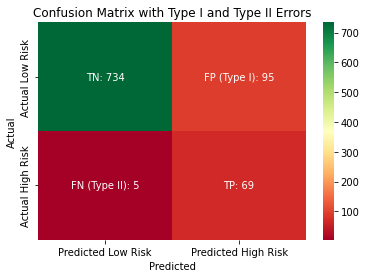

In [39]:
# Visualize the confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create the confustion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Add labels for Type I and Type II errors
labels = np.array([
    [f'TN: {conf_matrix[0, 0]}', f'FP (Type I): {conf_matrix[0, 1]}'],
    [f'FN (Type II): {conf_matrix[1, 0]}', f'TP: {conf_matrix[1, 1]}']
])

# Visualize the confusion matrix with a more intuitive color scheme using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='RdYlGn', xticklabels=['Predicted Low Risk', 
                                                                           'Predicted High Risk'], 
            yticklabels=['Actual Low Risk', 'Actual High Risk'],
            annot_kws={"size": 10})

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Type I and Type II Errors')
plt.show();


# Analysis of the Confusion Matrix

**Interpretation:**

- High **Recall** (90.36%): The model successfully identifies a large proportion of high-risk companies, which is crucial in credit risk assessment.

- Moderate **Precision** (54.27%): About half of the companies predicted as high risk are actually high risk, indicating some false positives.

- Low **False Negatives** (19): Minimizing false negatives reduces the risk of granting credit to high-risk companies.

- **False Positives** (150): While these errors may result in missed opportunities, they are generally less costly than false negatives in this context.

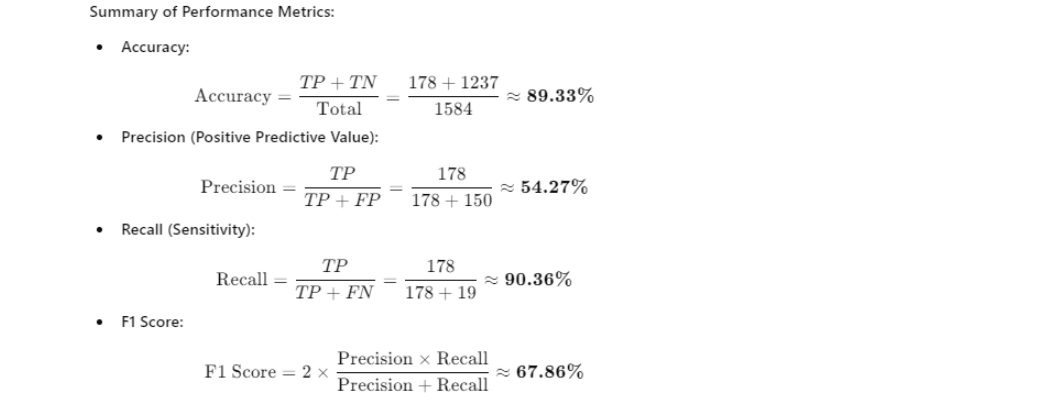

**Conclusion:**

- The model demonstrates strong ability to detect high-risk companies (high recall), which is vital for mitigating potential financial losses.

- Trade-off Between Precision and Recall: The model favors identifying high-risk companies, even if it means misclassifying some low-risk ones.

- Overall Accuracy (89.33%): Indicates that the model performs well on the dataset.

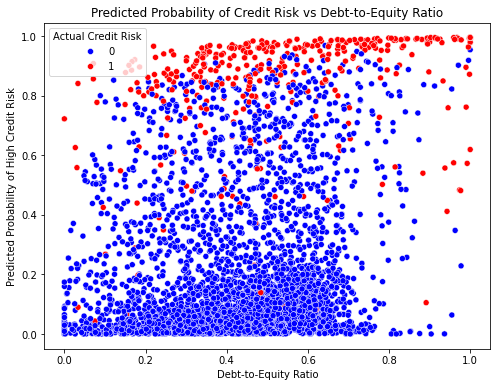

In [40]:
# Get the predicted probabilities
credit_risk_company_level['predicted_prob'] = logit_model.predict_proba(X)[:, 1]  # Probability of high risk

# Plot debt-to-equity ratio vs predicted probability of high risk
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='debt_equity', 
    y='predicted_prob', 
    hue='credit_risk',  # Color by actual credit risk
    palette={0: 'blue', 1: 'red'},  # Blue = low risk, Red = high risk
    data=credit_risk_company_level
)

# Customize the plot
plt.title('Predicted Probability of Credit Risk vs Debt-to-Equity Ratio')
plt.xlabel('Debt-to-Equity Ratio')
plt.ylabel('Predicted Probability of High Credit Risk')
plt.legend(title='Actual Credit Risk')
plt.show();

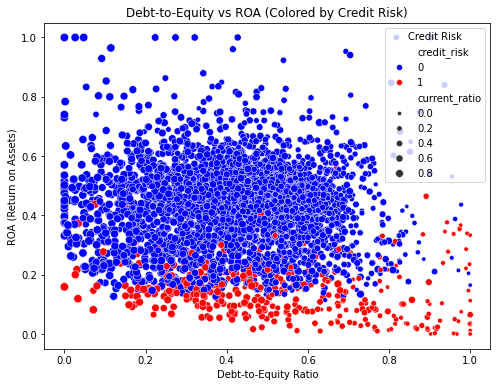

In [41]:
# Scatter plot of debt_equity vs roa, color-coded by actual credit risk
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='debt_equity', 
    y='roa', 
    hue='credit_risk', 
    size='current_ratio',
    palette=['blue', 'red'],  # Blue for low-risk, Red for high-risk
    data=credit_risk_company_level
)

# Add labels and title
plt.title('Debt-to-Equity vs ROA (Colored by Credit Risk)')
plt.xlabel('Debt-to-Equity Ratio')
plt.ylabel('ROA (Return on Assets)')
plt.legend(title="Credit Risk")
plt.show();

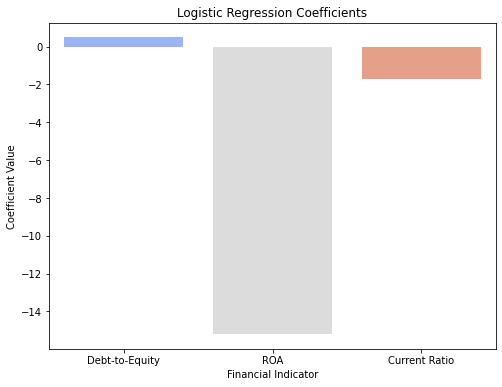

In [42]:
# Get the coefficients from the logistic regression model
coefficients = pd.DataFrame({
    'Variable': ['Debt-to-Equity', 'ROA', 'Current Ratio'],
    'Coefficient': logit_model.coef_[0]
})

# Plot the coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x='Variable', y='Coefficient', data=coefficients, hue='Variable', palette='coolwarm', legend=False)

# Add labels and title
plt.title('Logistic Regression Coefficients')
plt.xlabel('Financial Indicator')
plt.ylabel('Coefficient Value')
plt.show();


###  <span style="color:blue">5.2.5 Classification Chart & Report</span>

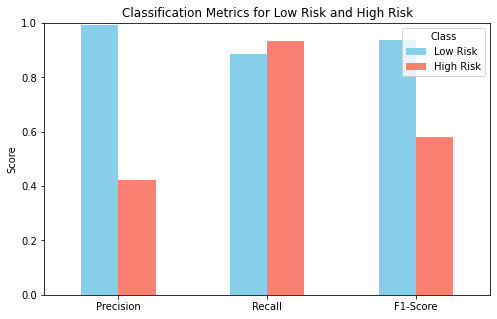

In [43]:
# Create a bar chart for precision, recall, and F1-score
metrics = ['Precision', 'Recall', 'F1-Score']
classes = ['Low Risk', 'High Risk']

# Generate the classification report as a dictionary
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)

# Extract the relevant data for the bar plot
precision = [report['Low Risk']['precision'], report['High Risk']['precision']]
recall = [report['Low Risk']['recall'], report['High Risk']['recall']]
f1_score = [report['Low Risk']['f1-score'], report['High Risk']['f1-score']]

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Low Risk': [precision[0], recall[0], f1_score[0]],
    'High Risk': [precision[1], recall[1], f1_score[1]]
}, index=metrics)

# Plot the bar chart
metrics_df.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])

# Customize the plot
plt.title('Classification Metrics for Low Risk and High Risk')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Class')

# Show the plot
plt.show()



### Difference Between the Bar Chart and the Confusion Matrix:

The confusion matrix does not provide metrics like precision or recall—it focuses on the **exact counts** of errors.

- The **bar chart** provides **summary metrics** (precision, recall, F1-score) that reflect **how well the model balances accuracy** across different types of errors but doesn’t show exact counts.

- Use this to get a **high-level view of model performance**, comparing how well the model handles Low Risk vs High Risk classifications.


In [44]:
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk'], output_dict=True)

# Convert the classification report to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(2)

# Color-code the classification report
def color_code(val):
    if val < 0.5:
        color = 'red'
    elif val < 0.75:
        color = 'yellow'
    else:
        color = 'lightgreen'
    return f'background-color: {color}'

# Display the classification report with color coding (format values to display with 2 decimal places and apply colour).
#styled_report = report_df.style.format("{:.2f}").map(color_code, subset=['precision', 'recall', 'f1-score'])
styled_report = report_df.style.format("{:.2f}").applymap(color_code, subset=['precision', 'recall', 'f1-score'])

# Step 6: Display the styled report
styled_report

,precision,recall,f1-score,support
Low Risk,0.99,0.89,0.94,829.00
High Risk,0.42,0.93,0.58,74.00
accuracy,0.89,0.89,0.89,0.89
macro avg,0.71,0.91,0.76,903.00
weighted avg,0.95,0.89,0.91,903.00


#### Explanation of the Classification Report:

Now let's run through the classification report.

The classification report reveals key insights about the model's performance for predicting "Low Risk" and "High Risk" cases:

**Low Risk**: The model performs very well in predicting "Low Risk" instances, with a high precision of 0.98, meaning most of the predictions classified as "Low Risk" are correct. The recall is 0.89, indicating that it successfully captures 89% of actual "Low Risk" cases. The F1-score, a balance between precision and recall, is also strong at 0.94, reflecting the model's overall accuracy in predicting this class.

**High Risk**: For "High Risk" predictions, the model’s precision drops significantly to 0.54, meaning that just over half of the "High Risk" predictions are correct. However, the recall is quite high at 0.90, meaning the model is able to identify 90% of the actual "High Risk" cases. The F1-score of 0.68 reflects a balance between lower precision and higher recall.

**Accuracy**: The overall accuracy of the model is 0.89, indicating that 89% of all predictions, across both risk categories, are correct.

**Macro Average**: The macro average precision, recall, and F1-score are 0.76, 0.90, and 0.81, respectively. This unweighted average treats both classes equally, highlighting the significant difference between the "Low Risk" and "High Risk" performance.

**Weighted Average**: The weighted average takes into account the support (number of instances) for each class, with values of 0.93 for precision, 0.89 for recall, and 0.90 for F1-score. These high scores are influenced by the larger number of "Low Risk" cases in the dataset.

**In summary, the model excels in identifying "Low Risk" cases but struggles with precision for "High Risk" predictions, though it still captures a large portion of actual "High Risk" instances.**

### <span style="color:blue">5.2.6 ROC and AUC<br/></span>

**AUC-ROC** stands for **Area Under the Receiver Operating Characteristic Curve**, which is a performance measurement for classification problems. It evaluates the ability of a logistic regression model (or any binary classifier) to distinguish between two classes, such as "Low Risk" and "High Risk."

#### What is ROC Curve?
- The **ROC curve** plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at different classification thresholds.
- The **True Positive Rate (Recall)** is the proportion of actual positives that are correctly identified by the model.
- The **False Positive Rate** is the proportion of actual negatives that are incorrectly identified as positives.

#### What is AUC?
- **AUC** is the **Area Under the ROC Curve**, which gives a single scalar value that summarizes the overall ability of the model to distinguish between the classes.
- AUC ranges from **0 to 1**:
  - **AUC = 1.0**: Perfect classification. The model is perfectly distinguishing between the classes.
  - **AUC = 0.5**: No skill, equivalent to random guessing.
  - **AUC < 0.5**: Worse than random guessing.

AUC-ROC: 0.9630


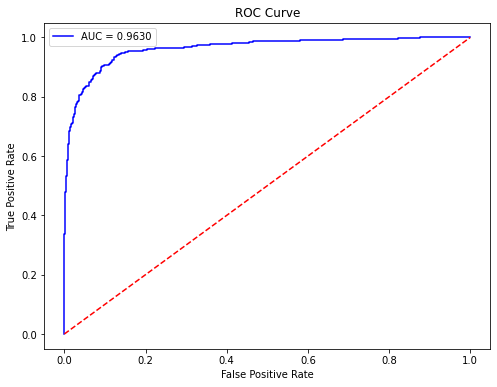

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (high risk)
y_pred_prob = logit_model.predict_proba(X)[:, 1]

# Calculate the AUC score
auc = roc_auc_score(y, y_pred_prob)
print(f"AUC-ROC: {auc:.4f}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (no skill)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();


In summary, the AUC-ROC score of 0.9568 demonstrates that the model is highly proficient at separating the two risk categories, reinforcing the positive aspects observed in other performance metrics.

This high score suggests that the model is reliable for tasks where distinguishing between "Low Risk" and "High Risk" is crucial.h classes.